In [1]:
import numpy as np
import sbi

# import lal as _lal
# from pycbc.waveform import get_fd_waveform
# from pycbc.psd import aLIGOZeroDetHighPower
# from pycbc.filter import highpass

import matplotlib
import matplotlib.pyplot as plt

import torch

from sbi import analysis as analysis
from sbi.analysis import pairplot
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from sbi.neural_nets import posterior_nn
from sklearn.preprocessing import StandardScaler

from sbi.neural_nets.embedding_nets import (
    FCEmbedding,
    CNNEmbedding,
    PermutationInvariantEmbedding
)

In [ ]:
# take real part
def simulator_1d(theta):

    # theta = [A, t_c]
    f_lower = 20
    f_final = 80
    delta_f = 1/16
    n_freq = int(np.round((f_final - f_lower) / delta_f + 1,0))

    num_sim = theta.shape[0]
    #print(theta)

    f_array = np.linspace(f_lower, f_final, n_freq)
    h_freq = np.zeros(shape = (num_sim, len(f_array)))
    for i in range(num_sim):
        Alog = theta[i,0].numpy()
        A = 10 ** Alog
        tc = theta[i,1].numpy()
        noise_scale = A
        #print(tc, tc.type())

        h_freq[i, :] = (A * f_array ** (-7/6) * np.e ** (2j * np.pi * f_array * tc)).real
        h_freq[i] += 0.01 * noise_scale * np.random.standard_normal(size=n_freq)

        # Optional different normalization for noise that creates noise of the correct order of magnitude
        # h_freq[i] += A * f_array**(-7/6) * np.random.standard_normal(size=n_freq)

    h_freq = torch.tensor(h_freq, dtype=torch.float32)
    return h_freq


# normalization for every frequency
def normalize_1d(h_freq):
    mean = h_freq.mean(dim=0, keepdim=True)  # Mean per frequency bin
    std = h_freq.std(dim=0, keepdim=True)   # Std per frequency bin
    h_freq_normalized = (h_freq - mean) / (std)
    return h_freq_normalized, mean, std

def normalize_2d(h):
    h_freq_normalized = torch.tensor(np.zeros(shape = h.shape))
    h_freq_normalized[:,0,:], mean_real, std_real = normalize_1d(h[:,0,:])
    h_freq_normalized[:,1,:], mean_imag, std_imag = normalize_1d(h[:,1,:])
    return h_freq_normalized, mean_real, mean_imag, std_real, std_imag

# global normalization
def normalize_1d_(h_freq):
    mean = h_freq.mean()
    std = h_freq.std()
    h_freq_normalized = (h_freq - mean) / (std)
    return h_freq_normalized, mean, std

def normalize_obs_1d(h_obs, mean, std):
    h_obs_normalized = (h_obs - mean) / (std)
    return h_obs_normalized

In [3]:
num_sim = 5000
Alog_lowerbound = -21
Alog_upperbound = -19
tc_lowerbound = 0.01
tc_upperbound = 0.5
noise_scale = 10**(Alog_lowerbound)

prior = BoxUniform(low=torch.tensor([Alog_lowerbound, tc_lowerbound]),
                   high=torch.tensor([Alog_upperbound, tc_upperbound]))


# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_1d = process_simulator(simulator_1d, prior, prior_returns_numpy)
check_sbi_inputs(simulator_1d, prior)

# Create inference object. Here, NPE is used.
#custom_density_estimator = posterior_nn(model = 'zuko_maf', hidden_features = [64]*3, num_transforms = 5)


# #generate simulations and pass to the inference object
# theta, h_freq = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim)
# inference = inference.append_simulations(theta, h_freq)


theta_prior = prior.sample((num_sim,))
h_sim = simulator_1d(theta_prior)

# Normalize the parameters in the prior
scaler = StandardScaler()
scaler.fit(theta_prior.numpy())
theta_prior_normalized = torch.tensor(scaler.transform(theta_prior.numpy()))
#theta = scaler.inverse_transform(theta_normalized)

# Normalize the data
h_sim_normalized, mean, std = normalize_1d_(h_sim)

# prior norm that includes +-3sigma
prior_norm = BoxUniform(low=torch.tensor([-3, -3]),
                        high=torch.tensor([3, 3]))

custom_density_estimator = posterior_nn(model = 'zuko_maf', hidden_features = [64]*3, num_transforms = 5)
#inference = NPE(prior=prior_norm, density_estimator='zuko_maf')
inference = NPE(prior=prior_norm, density_estimator=custom_density_estimator)
inference = inference.append_simulations(theta_prior_normalized, h_sim_normalized)


# # train the density estimator and build the posterior
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)


 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

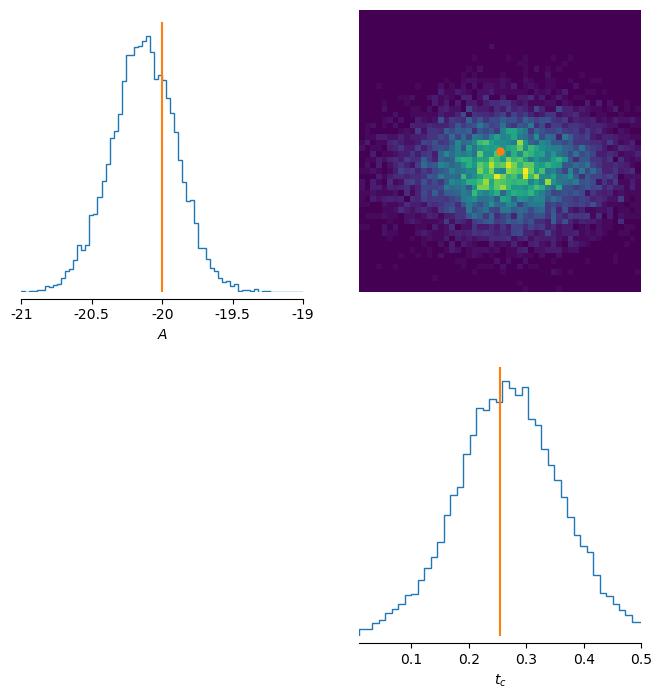

In [4]:
# Fixed theta_true at center of distribution for testing
# theta_true = prior.sample((1,))
theta_true = prior.mean.reshape(1,2)

# generate our observation
h_obs = simulator_1d(theta_true)
h_obs_normalized = normalize_obs_1d(h_obs, mean, std)

samples_normalized = posterior.sample((10000,), x=h_obs_normalized)



# Inverse the normalization of the parameters
samples = torch.tensor(scaler.inverse_transform(samples_normalized.numpy()))

_ = analysis.pairplot(
    samples,
    limits=[[Alog_lowerbound, Alog_upperbound],
            [tc_lowerbound, tc_upperbound]],
    figsize=(8, 8),
    labels=[r"$A$", r"$t_c$"],
    points=theta_true # add ground truth thetas,
)

# plt.savefig("Gravitational Wave Posterior")
# plt.close()

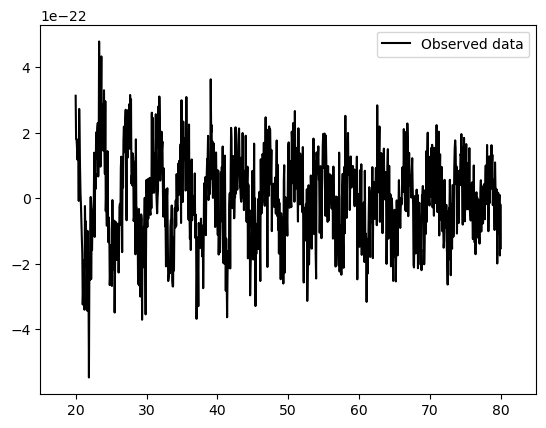

In [5]:
f_lower = 20
f_final = 80
delta_f = 1/16
freq_range = np.arange(f_lower, f_final+delta_f, delta_f)
sample_count = 20
sampled_color = 'b'
sampled_alpha = 0.2
observed_color = 'k'

plt.plot(freq_range, h_obs.numpy()[0], observed_color, label='Observed data')
plt.xlim(15, 85)
plt.legend()

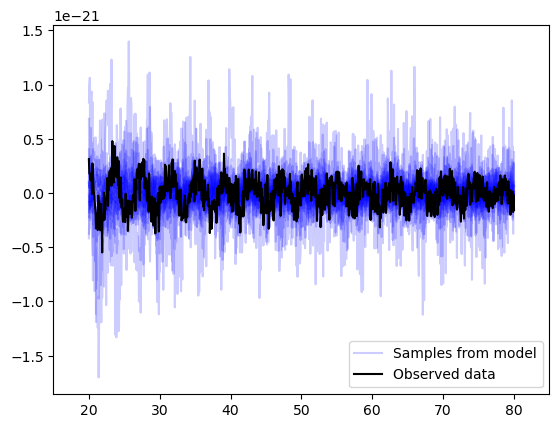

In [6]:
# plot samples
for sample_theta in samples[:sample_count-1]:
    h_sampled = simulator_1d(sample_theta.reshape(1,2))
    plt.plot(freq_range, h_sampled.numpy()[0], sampled_color, alpha=sampled_alpha)

# plot last sample separately for the legend
plt.plot(freq_range, simulator_1d(samples[sample_count-1].reshape(1,2)).numpy()[0], sampled_color, alpha=sampled_alpha, label='Samples from model')

plt.plot(freq_range, h_obs.numpy()[0], observed_color, label='Observed data')
plt.xlim(15, 85)
plt.legend()

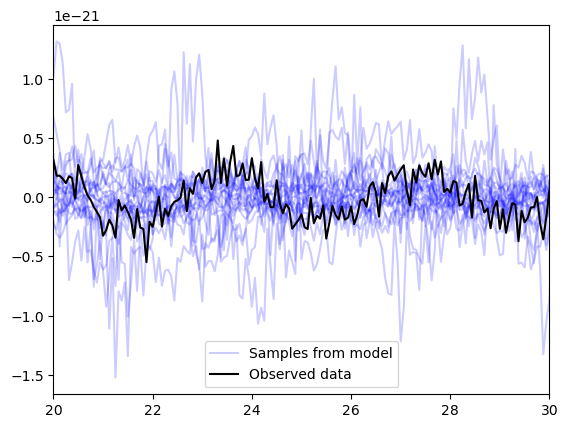

In [7]:
for sample_theta in samples[:sample_count-1]:
    h_sampled = simulator_1d(sample_theta.reshape(1,2))
    plt.plot(freq_range, h_sampled.numpy()[0], 'b', alpha=0.2)
plt.plot(freq_range, simulator_1d(samples[sample_count-1].reshape(1,2)).numpy()[0], sampled_color, alpha=sampled_alpha, label='Samples from model')
plt.plot(freq_range, h_obs.numpy()[0], observed_color, label='Observed data')
plt.xlim(20, 30)
plt.legend()